<a href="https://colab.research.google.com/github/JasonWu2020/ECE188_Project2/blob/main/Task_2_Jason_Wu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Perform an Adversarial attack.

For the second part of the project we consider a trained model (MobileNet) which is trained on the imagenet dataset. 

We use an evasion attack called [FGSM](https://neptune.ai/blog/adversarial-attacks-on-neural-networks-exploring-the-fast-gradient-sign-method#:~:text=The%20Fast%20Gradient%20Sign%20Method%20(FGSM)%20combines%20a%20white%20box,model%20into%20making%20wrong%20predictions.) to fool the neural network into making incorrect predictions.

## Import Packages.

Import the necessary packages we continue to use Tensorflow and Keras

In [ ]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
from keras.preprocessing import image

mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False

## Load the Pretrained model. 

We use the [MobileNetV2](https://arxiv.org/abs/1801.04381) model trained on the [Imagenet](https://www.image-net.org/) dataset. 

In [ ]:
pretrained_model = tf.keras.applications.MobileNetV2(include_top=True,
                                                     weights='imagenet')
pretrained_model.trainable = False

# ImageNet labels
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

### Helper Function for Data Processing


Following functions can be used for data processing. Dont worry about these, just use them. 

In [ ]:
# Helper function to preprocess the image so that it can be inputted in MobileNetV2
def preprocess(image):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (224, 224))
  image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
  image = image[None, ...]
  return image

# Helper function to extract labels from probability vector
def get_imagenet_label(probs):
  return decode_predictions(probs, top=1)[0][0]

## Load an Image. 


Load any image, we consider an image of a Golden Retriever. 

In [ ]:
image_raw = tf.io.read_file('/content/drive/MyDrive/ML pics/KITTYV2.jpg')
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

49152/35363 [=========================================] - 0s 0us/step


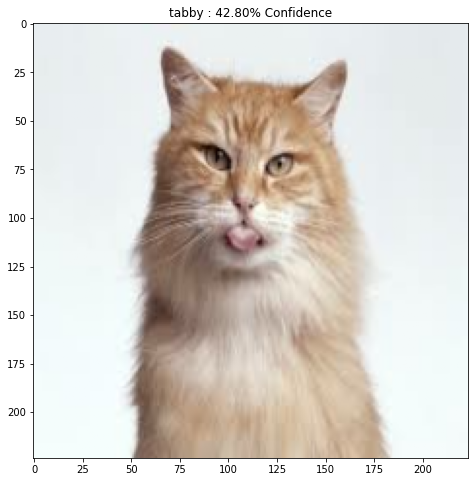

In [ ]:
plt.figure()
plt.imshow(image[0] * 0.5 + 0.5)  # To change [-1, 1] to [0,1]
_, image_class, class_confidence = get_imagenet_label(image_probs)
plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))
plt.show()

## Create the Adversarial Image. 

We use the FGSM method to create an adversarial image. Be sure to read about FGSM to understand how the attack works. 

In [ ]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = pretrained_model(input_image)
    loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad

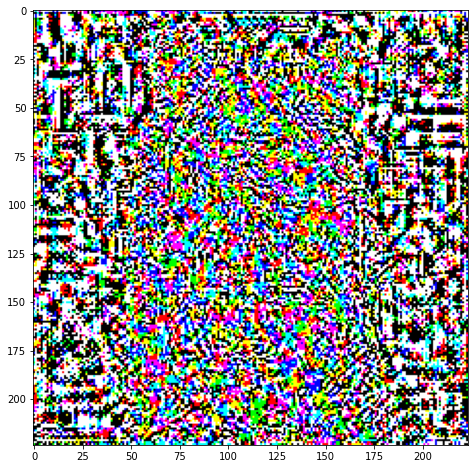

In [ ]:
# Get the input label of the image.
cat_index= 283
label = tf.one_hot(cat_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]

In [ ]:
def display_images(image, description):
  _, label, confidence = get_imagenet_label(pretrained_model.predict(image))
  plt.figure()
  plt.imshow(image[0]*0.5+0.5)
  plt.title('{} \n {} : {:.2f}% Confidence'.format(description,
                                                   label, confidence*100))
  plt.show()

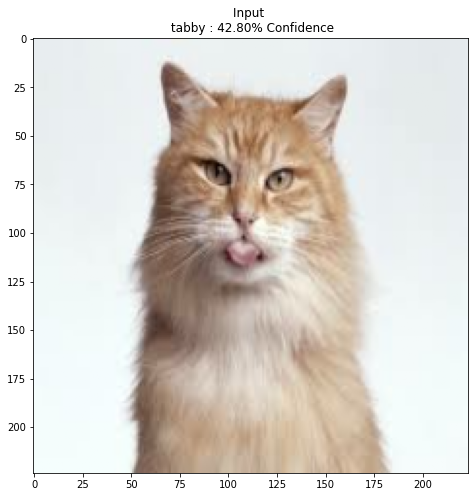

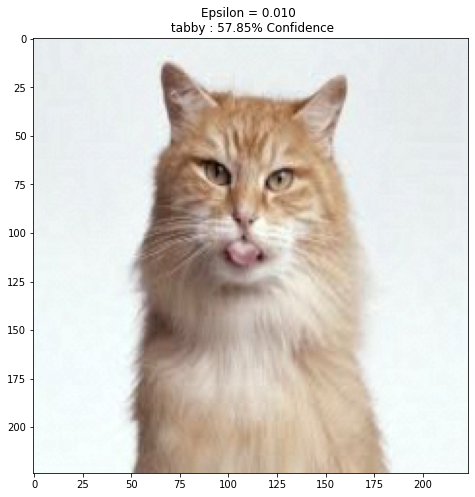

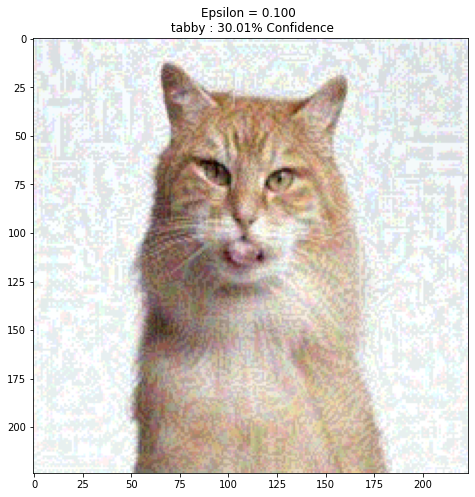

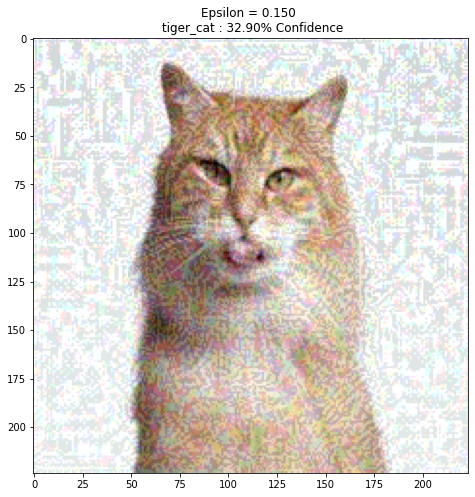

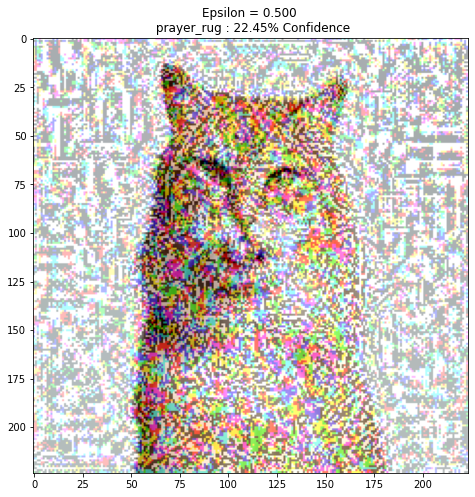

In [ ]:
epsilons = [0, 0.01, 0.1, 0.15, 0.5]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)
  display_images(adv_x, descriptions[i])

# Task2: Perform an Analysis to understand the potency of the attack. 

Your task here is to understand how small a change could change the class output and this is measured by the epsilon value needed to change the class. 

Your task is as follows:

* Pick 10 images each from different classes in imagenet. 
* Perform a perturbation analysis on each of these images. 
* In the analysis you are required to report the smallest epsilon value for which you notice a class change. 
* Make a table for each of the images considered with the minimum epsilon value for the FGSM attack. 

Write the Code for the above below. You can add the table also below. 

In [ ]:
image_raw = tf.io.read_file('/content/drive/MyDrive/ML pics/BUSSING.jpg')
image = tf.image.decode_image(image_raw)
image = preprocess(image)
img_index= 779

label = tf.one_hot(img_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))
perturbations = create_adversarial_pattern(image, label)

predicted_label = ""
actual_label = ""
epsilon = 0
sameLabel=True
while (predicted_label == actual_label):
  adv_img = image + epsilon * perturbations
  _, label, confidence = get_imagenet_label(model2.predict(adv_img))
  predicted_label = label
  epsilon = epsilon + 0.005
  print(epsilon)
  actual_label = "school_bus"
print("Predicted " + predicted_label + " with epsilon of " + str(epsilon))


ValueError: ignored

School Bus: Epsilon = 0.24 yields jigaw puzzle

Peacock: Epsilon = 0.025 yields coral reef

Border Terrier: Epsilon = 0.01 yields meerkat

Hamster: Epsilon = 0.015 yields Guinea Pig

Abacus: Epsilon = 0.02 yields Pencil Box

Table Lamp: Epsilon = 0.015 yields Paper Towel

Groenendael: Epsilon = 0.01 yields Kelpie

Airliner: Epsilon = 0.025 predicts warplane

Chainsaw: Epsilon = 0.125 predicts Shopping Basket

Electric Fan: Epsilon = 0.125 predicts Manhole Cover









# Task3: Compare the robustness of the considered model with other models. 

Your task here is to compare how this model (MobileNetV2) compares with other popular object detection models. 

Your task is as follows:

* Consider 5 different models (you can consider various RESNET architectures, any models you find interesting).
* Load the pre-trained weights of the model (trained on imagenet). 
* Perform Task2 on all the considered models. 
* Add all the results in the table. Hence the final table you have 6 columns for each model and epsilon values for each of the 10 images for all 6 models. 


What do you observe? Why do you think this is the case? 

Write the Code for the above below. You can also add the table and answer to the question below. 


In [ ]:
model1 = tf.keras.applications.MobileNetV2(include_top=True,
                                                     weights='imagenet')
model2 = tf.keras.applications.NASNetMobile(include_top=True,
                                                     weights='imagenet')                                                    
model3 = tf.keras.applications.DenseNet121(include_top=True,
                                                      weights='imagenet')
model4 = tf.keras.applications.DenseNet169(include_top=True,
                                                      weights='imagenet')
model5 = tf.keras.applications.DenseNet201(include_top=True,
                                                     weights='imagenet')
model6 = tf.keras.applications.MobileNet(include_top=True,
                                                     weights='imagenet')

24240128/24227760 [==============================] - 1s 0us/step


In [ ]:
image_raw = tf.io.read_file('/content/drive/MyDrive/ML pics/fan.png')
image = tf.image.decode_image(image_raw)
image = preprocess(image)
img_index= 545

label = tf.one_hot(img_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))
perturbations = create_adversarial_pattern(image, label)

predicted_label = ""
actual_label = ""
epsilon = -0.005
sameLabel=True
while (predicted_label == actual_label):
  epsilon = epsilon + 0.005
  print(epsilon)
  adv_img = image + epsilon * perturbations
  _, label, confidence = get_imagenet_label(model6.predict(adv_img))
  predicted_label = label
  actual_label = "electric_fan"
print("Predicted " + predicted_label + " with epsilon of " + str(epsilon))

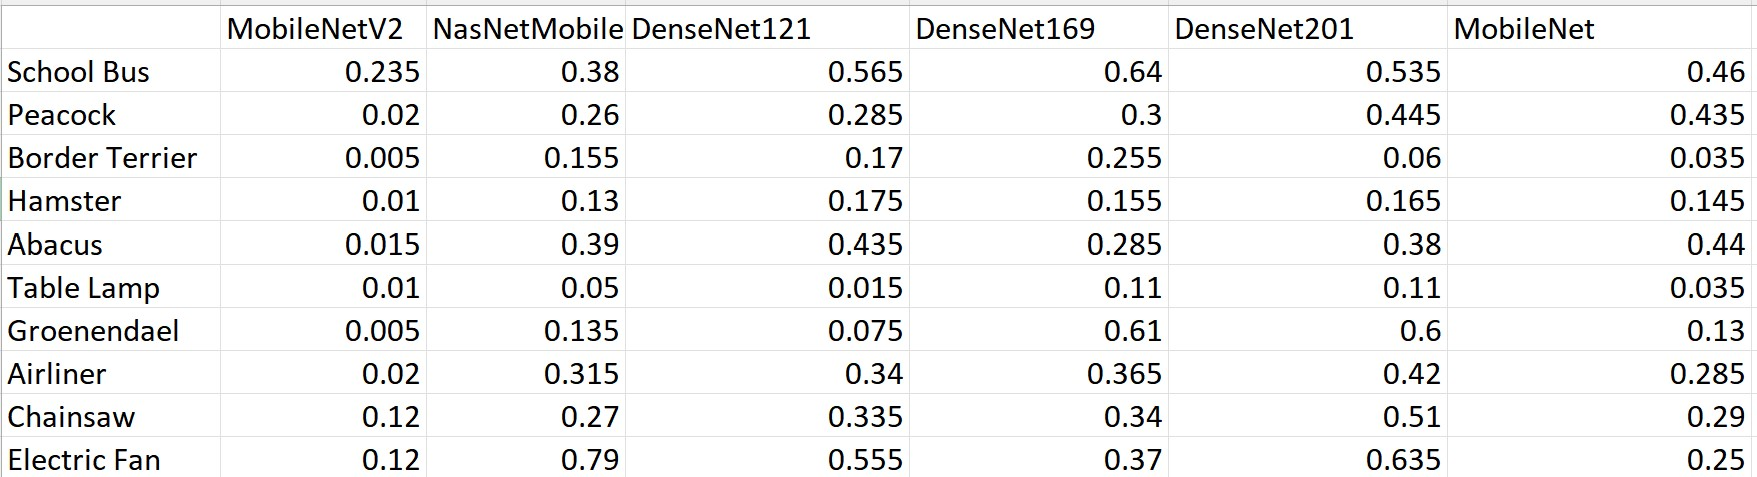

We see that MobileNet is actually more resilient to adversarial attacks that MobileNetV2, which is surprising. One possible explanation is that MobileNetV2 is a more complicated architecture, so there is more complexity for the FGSM to attack. We can see that across the DenseNets, there isn't a clear best or worst performing model, indicating that they all may be advesarially trained and have some resilience to FGSM attacks. 

# BONUS: Can you provide a better attack?

Can you design a better attack that lowers the epsilon required for the images?

Task:

* Design another attack. 
* Compare the epsilon values on 10 images. 
* Does it perform better than the FGSM attack? That is, does it have lower epsilon values?

Write the code and provide your answers below. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Border_terrier


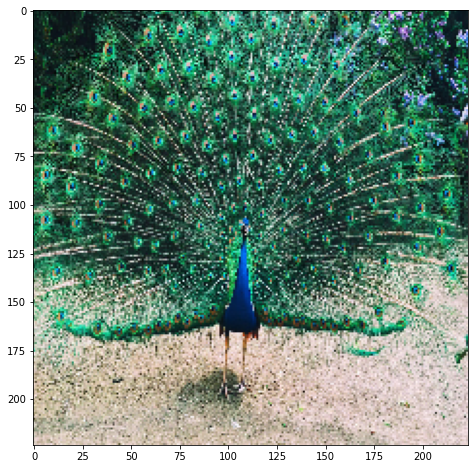

In [ ]:
image_raw = tf.io.read_file('/content/drive/MyDrive/ML pics/peacock-feathers.jpg')
image = tf.image.decode_image(image_raw)
image = preprocess(image)
img_index= 84

label = tf.one_hot(img_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))
step = 0.001
adv_image = image
for i in range(10):
  perturbation = create_adversarial_pattern(adv_image, label)
  adv_image = adv_image + step * perturbation

_, label, confidence = get_imagenet_label(pretrained_model.predict(adv_img))
print(label)
plt.figure()
plt.imshow(adv_image[0]*0.5+0.5)

Using iterative FGM by adding perturbations to the modified adverarial image can result in a more effective attack, as we continually update the gradient to ensure that the highest loss is achieved. 